In [1]:
import functions as fct
import re
import warnings
import numpy as np
import pandas as pd
from joblib import dump, load
from tqdm import tqdm

# Visu
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()

# preprocessing sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer



warnings.simplefilter(action='ignore', category=FutureWarning)



  # Chargement des données

In [2]:
application_train = pd.read_csv('../01_DATA/application_train.csv')
POS_CASH_balance = pd.read_csv('../01_DATA/POS_CASH_balance.csv')
bureau_balance = pd.read_csv('../01_DATA/bureau_balance.csv')
previous_application = pd.read_csv('../01_DATA/previous_application.csv')
installments_payments = pd.read_csv('../01_DATA/installments_payments.csv')
credit_card_balance = pd.read_csv('../01_DATA/credit_card_balance.csv')
bureau = pd.read_csv('../01_DATA/bureau.csv')



In [3]:
liste_fichiers = [application_train, POS_CASH_balance, bureau_balance,
                  previous_application, installments_payments, credit_card_balance,
                  bureau]
liste_noms_fichiers = ['application_train', 'POS_CASH_balance', 'bureau_balance',
                       'previous_application', 'installments_payments', 'credit_card_balance',
                       'bureau']

In [4]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# # attribution nom à chaque fichier pour pouvoir les parcourir ensuite et retrait 
# # première colonne 'unnamed:0'
# for nom, file in zip(liste_noms_fichiers, liste_fichiers):
#     file.name = nom
#     # file.drop('Unnamed: 0', axis=1, inplace=True)

# # Enregistrement target et identifiant des clients à part
# target = application_train["TARGET"]
# target.index = application_train.SK_ID_CURR

# client_ID = application_train["SK_ID_CURR"]

 # Nettoyage et création de features

In [6]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


 ## Application_train

In [7]:
# CODE_GENDER : retrait des lignes avec XNA
print(application_train.shape)
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']
print(application_train.shape)


(307511, 122)
(307507, 122)


In [8]:
# anomalie sur la variable Days_employed
masque = (application_train.DAYS_EMPLOYED == 365243)
# creation d'une colonne pour stocker l'info anomalie / non  anomalie
application_train['DAYS_EMPLOYED_ANOM'] = [1 if masque[x] == True else 0 for x in list(masque.index)]

# remplacement des valeurs anormales par np.NaN
application_train.DAYS_EMPLOYED.replace({365243: np.nan}, inplace=True)

C:\Users\Helene\AppData\Local\Temp/ipykernel_48956/3125038070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train['DAYS_EMPLOYED_ANOM'] = [1 if masque[x] == True else 0 for x in list(masque.index)]
c:\Users\Helene\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [9]:
# Feature engineering (pourcentages)
application_train['DAYS_EMPLOYED_PERC'] = application_train['DAYS_EMPLOYED'] / \
    application_train['DAYS_BIRTH']
application_train['INCOME_CREDIT_PERC'] = application_train['AMT_INCOME_TOTAL'] / \
    application_train['AMT_CREDIT']
application_train['INCOME_PER_PERSON'] = application_train['AMT_INCOME_TOTAL'] / \
    application_train['CNT_FAM_MEMBERS']
application_train['ANNUITY_INCOME_PERC'] = application_train['AMT_ANNUITY'] / \
    application_train['AMT_INCOME_TOTAL']
application_train['PAYMENT_RATE'] = application_train['AMT_ANNUITY'] / \
    application_train['AMT_CREDIT']


C:\Users\Helene\AppData\Local\Temp/ipykernel_48956/642283841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train['DAYS_EMPLOYED_PERC'] = application_train['DAYS_EMPLOYED'] / \
C:\Users\Helene\AppData\Local\Temp/ipykernel_48956/642283841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train['INCOME_CREDIT_PERC'] = application_train['AMT_INCOME_TOTAL'] / \
C:\Users\Helene\AppData\Local\Temp/ipykernel_48956/642283841.py:6: SettingWithCopyWarning: 
A value is trying to be set o

<AxesSubplot:>

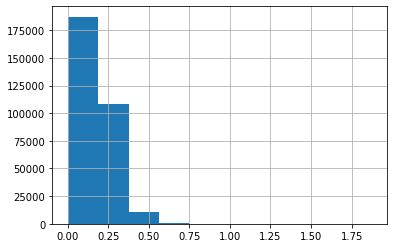

In [10]:
application_train.ANNUITY_INCOME_PERC.hist()

<AxesSubplot:>

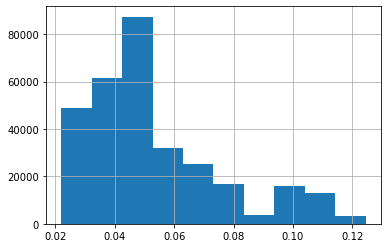

In [11]:
application_train['PAYMENT_RATE'].hist()

 ## Bureau_balance & bureau

In [12]:
nan_as_category = True
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
bureau_balance, bureau_balance_cat = one_hot_encoder(
    bureau_balance, nan_as_category)


In [13]:
# Bureau balance: aggregation et merge avec bureau.csv
# liste des aggregations : données numeriques min/max/size // données catégorielles moyenne du oneHot (equivalent à une proportion)
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bureau_balance_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
# renommage des features intialement catégorielles dans bureau_balance et maintenant exprimées en proportion
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                           for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)


In [14]:
# Dico des aggregations pour les features numeriques de Bureau et bureau_balance 
# pour les données déjà aggrégées de bureau_balance :
# months_balance_min : MIN // max : MAX // size : mean et sum
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}


In [15]:
# Features catégorielles de Bureau et bureau_balance
# liste des aggregations : données catégorielles moyenne du oneHot (equivalent à une proportion)
# pour les données déjà aggrégées de bureau_balance :
# moyenne de la moyenne déjà calculée
cat_aggregations = {}
for cat in bureau_cat:
    cat_aggregations[cat] = ['mean']
for cat in bureau_balance_cat:
    cat_aggregations[cat + "_MEAN"] = ['mean']
bureau_agg = bureau.groupby('SK_ID_CURR').agg(
    {**num_aggregations, **cat_aggregations})
# renommage des colonnes avec le prefixe BUREAU
bureau_agg.columns = pd.Index(
    ['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])


In [16]:
# Bureau: focus sur les credits actifs - aggregation uniquement sur les données numériques
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(
    ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')


In [17]:
# Bureau: focus sur les credits cloturés - aggregation  uniquement des features numériques
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(
    ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')


 ## previous applications

In [18]:
previous_application, cat_cols = one_hot_encoder(
    previous_application, nan_as_category=True)
# Days 365.243 values -> nan
previous_application['DAYS_FIRST_DRAWING'].replace(
    365243, np.nan, inplace=True)
previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(
    365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)


In [19]:
# Feature engineering :ratio credit demandé / credit accordé
previous_application['APP_CREDIT_PERC'] = previous_application['AMT_APPLICATION'] / \
    previous_application['AMT_CREDIT']


In [20]:
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}


In [21]:
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = previous_application.groupby('SK_ID_CURR').agg(
    {**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(
    ['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])


In [22]:
# Previous Applications: demandes de credits appouvées - aggregation uniquement des features numériques
approved = previous_application[previous_application['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(
    ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')


In [23]:
# Previous Applications: demandes de credits refusées - aggregation uniquement des features numériques
refused = previous_application[previous_application['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(
    ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')


 ## POS_CASH_Balance

In [24]:
POS_CASH_balance, cat_cols = one_hot_encoder(
    POS_CASH_balance, nan_as_category=True)


In [25]:
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = POS_CASH_balance.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(
    ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])


In [26]:
# nombre de POS cash count par clients ayant un credit actuellement
pos_agg['POS_COUNT'] = POS_CASH_balance.groupby('SK_ID_CURR').size()


 ## Installment_payments

In [27]:
installments_payments, cat_cols = one_hot_encoder(
    installments_payments, nan_as_category=True)


In [28]:
# Pourcentage et différences payées pour chaque tranche (montant payé et valeur de la tranche)
installments_payments['PAYMENT_PERC'] = installments_payments['AMT_PAYMENT'] / \
    installments_payments['AMT_INSTALMENT']
installments_payments['PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - \
    installments_payments['AMT_PAYMENT']
# Jours de retard (DPD) et jours avant échéance (DBD) (pas de valeurs négatives)
installments_payments['DPD'] = installments_payments['DAYS_ENTRY_PAYMENT'] - \
    installments_payments['DAYS_INSTALMENT']
installments_payments['DBD'] = installments_payments['DAYS_INSTALMENT'] - \
    installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['DPD'] = installments_payments['DPD'].apply(
    lambda x: x if x > 0 else 0)
installments_payments['DBD'] = installments_payments['DBD'].apply(
    lambda x: x if x > 0 else 0)


In [29]:
# Features: liste des aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = installments_payments.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(
    ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])


In [30]:
# Décompte des comptes de versements pour les tranches de remboursement de credits
ins_agg['INSTAL_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()


 ## credit_card_balance

In [31]:
credit_card_balance, cat_cols = one_hot_encoder(
    credit_card_balance, nan_as_category=True)


In [32]:
# aggregations
credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = credit_card_balance.groupby('SK_ID_CURR').agg(
    ['min', 'max', 'mean', 'sum', 'var'])
# renommage des colonnes avec le prefixe CC
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                           for e in cc_agg.columns.tolist()])


In [33]:
# Nombre de ligne par carte de credit
cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()


 ## Concatenation des différents fichiers

In [34]:
data = application_train.copy()
print(data.shape)
data = data.join(bureau_agg, how='left', on='SK_ID_CURR')
print(data.shape)
data = data.join(prev_agg, how='left', on='SK_ID_CURR')
print(data.shape)
data = data.join(pos_agg, how='left', on='SK_ID_CURR')
print(data.shape)
data = data.join(ins_agg, how='left', on='SK_ID_CURR')
print(data.shape)
data = data.join(cc_agg, how='left', on='SK_ID_CURR')
print(data.shape)

# l'index des lignes correspond à l'ID de la demande de prêt en cours
data = data.set_index('SK_ID_CURR')


(307507, 128)
(307507, 244)
(307507, 493)
(307507, 511)
(307507, 537)
(307507, 678)


# Encodage des variables catégorielles
## Selection des features categorielles

Deux cas de figure :
- variables booleennes (2 valeurs possibles)
- variables avec plus de 2 valeurs

In [35]:
# Selection des features qualitatives object
quali_obj = list(data.select_dtypes('object').columns)

# Selection des features booleennes (uniquement 2 valeurs)
regexp = '(FLAG_)|(REG_)|(LIVE_)'
## features int dnot le nom contient FLAG ou REG ou LIVE (indicateurs de variables categorielles/booleennes)
quali_BOOL = data.select_dtypes("int").columns
quali_BOOL = list(quali_BOOL[[bool(re.match(regexp, feature)) for feature in quali_BOOL]])
quali_BOOL += list(data.select_dtypes('bool').columns)
masque_bool = (data[quali_obj].nunique() == 2)
quali_BOOL += list(data[quali_obj].nunique()[masque_bool].index)
print("il y a {} variables booleennes".format(len(quali_BOOL)))

# Liste des features categorielles avec cardinalité > 2
masque_categ = (data[quali_obj].nunique() > 2)
quali_categ = list(data[quali_obj].nunique()[masque_categ].index)
print("il y a {} variables categorielles avec cardinalité > 2".format(len(quali_categ)))

il y a 37 variables booleennes
il y a 11 variables categorielles avec cardinalité > 2


In [36]:
fct.pourcent_NA_df(data[quali_categ])

Il y a 81.71% valeurs renseignées (soit 18.29 % de valeurs manquantes) dans l'intégralité du df


In [37]:
fct.pourcent_NA_df(data[quali_BOOL])

Il y a 98.72% valeurs renseignées (soit 1.28 % de valeurs manquantes) dans l'intégralité du df


In [38]:
liste_quali = quali_BOOL + quali_categ
len(liste_quali)

48

## Encodage
- variables booleennes : label_encoder (ordre n'a pas d'importance)
- variables avec une cardinalité > 2 : one hot encoder

In [39]:
def encode_labels(col, df):
    """Réalise l'encodage d'une variable catégorielle à 2 valeurs et retourne l'encodeur ainsi que le résultat de l'encodage"""
    df[col].replace(np.nan,'NaN', inplace=True)
    encoder = LabelEncoder()
    encoder.fit(df[col])
    col_values = pd.Series(encoder.transform(df[col]), index=df.index)
    return encoder, col_values

In [40]:
# def encode_onehot(cols, df):
#     """Réalise l'encodage onehot d'une variable catégorielle et retourne l'encodeur ainsi que le résultat de l'encodage"""
#     df.loc[:, cols].replace(np.nan,'NaN', inplace=True)
#     encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
#     encoder.fit(df[cols])
#     mat_cols = encoder.transform(df[cols])
#     df_categorical = pd.DataFrame(data=mat_cols, columns=encoder.get_feature_names_out(), index=df.index)
#     df = pd.concat([df, df_categorical], axis=1)
#     df.drop(columns=cols, inplace=True)
#     return encoder, df

In [41]:
# label_enc: Dictionnaire des encodeurs pour les variables catégorielles de type object à 2 valeurs 
label_enc = {}
for feature in quali_BOOL:
    label_enc[feature], data[feature] = encode_labels(feature, data)

In [42]:
# # onehot_enc: Dictionnaire des encodeurs pour les variables avec cardinalité > 2
# onehot_enc, data = encode_onehot(quali_categ, data)

# # names_quali: On enregistre la liste des variables catégorielles
# names_quali = quali_BOOL + onehot_enc.get_feature_names_out().tolist()

# print('il y a {} variables qualitatives après encodage'.format(len(names_quali)))

# Nettoyage

- variables représentant la valeur NaN contenue dans une variable catégorielle
- suppression des variables trop corrélées entre elles
- suppression des variables trop faiblement corrélées entre elles
- Outliers

## Variables correspondant à des NaN

In [43]:
regexp1, regexp2 = "XNA", 'nan'
# is_nan: Contient si la variable représente la présence de la valeur NaN
is_nan = np.array([bool(re.search(regexp1, col)) or bool(re.search(regexp2, col)) for col in data.columns])
# cols_nan: Colonnes représentant la valeur NaN dans une variable
cols_nan = data.columns[is_nan]
print("Il y a {} features qui représentent des valeurs NaN de variables catégorielles".format(len(cols_nan)))

Il y a 37 features qui représentent des valeurs NaN de variables catégorielles


In [44]:
data.drop(columns=cols_nan, inplace=True)
# On met à jour la liste de nos variables catégorielles
liste_quali = [feature for feature in liste_quali if feature not in cols_nan]
quali_categ = [feature for feature in quali_categ if feature not in cols_nan]
print("il reste {} variables categorielles".format(len(liste_quali)))

il reste 48 variables categorielles


## Suppression variables mal renseignées

In [45]:
# ratio_filled: Taux de remplissage des colonnes
ratio_filled = data.count()/len(data)
ratio_filled
# min_ratio: Taux de remplissage minimal nécessaire pour imputer une variable
min_ratio = 0.75
# to_drop: Colonnes creuses à supprimer
print("il y a {} variables qui ont un taux de remplissage inférieur à {}".format(sum(ratio_filled < min_ratio), min_ratio))
to_drop = data.columns[ratio_filled < min_ratio]
# on garde forcement les variables AMT_Annuity, AMT_income_total et AMT_credit
for feature_to_keep in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'SK_ID_CURR']:
    if feature_to_keep in to_drop:
        to_drop.remove(feature_to_keep)
print("%d variables insuffisamment renseignées" % (len(to_drop)))

# # Mise à jour du fichier
data_final = data.drop(columns=to_drop)
# On met à jour la liste de nos variables catégorielles
liste_quali = [feature for feature in liste_quali if feature not in to_drop]
quali_categ = [feature for feature in quali_categ if feature not in to_drop]
print("il reste {} variables categorielles".format(len(liste_quali)))
data_final.shape

il y a 286 variables qui ont un taux de remplissage inférieur à 0.75
286 variables insuffisamment renseignées
il reste 44 variables categorielles


(307507, 354)

## Outliers

In [46]:
# # liste des features quantitatives
masque_quali = data_final.columns.isin(liste_quali)
names_quanti = data_final.columns[~masque_quali]
print("il y a {} variables quantitatives".format(len(names_quanti)))

il y a 310 variables quantitatives


In [47]:
def drop_outliers_all(df, colonnes, nb_IQR):
    """
    suppression des lignes contenant des outliers selon une colonne
    """
    for col in colonnes:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3-Q1
        
        not_outlier = np.logical_and(Q1 - nb_IQR * IQR <= data[col], data[col] <= Q3 + nb_IQR * IQR)
        to_drop = ~(np.logical_or(not_outlier, data[col].isna()))
        if to_drop.sum() > 0:
            # print(col, ': suppression des {} valeurs inférieures à {}'.format(to_drop.sum(), (Q1 - nb_IQR * IQR)),
            #     'et supérieures à ', (Q3 + nb_IQR * IQR))
            df_final = df.drop(index=df.index[to_drop])
    return df_final


In [48]:
data_final = drop_outliers_all(data_final, names_quanti, nb_IQR=5)

## Variables redondantes = trop corrélées entre elles
### Variables quantitatives

In [49]:
# calcul de la matrice de corrélation 
corr = data_final.corr()

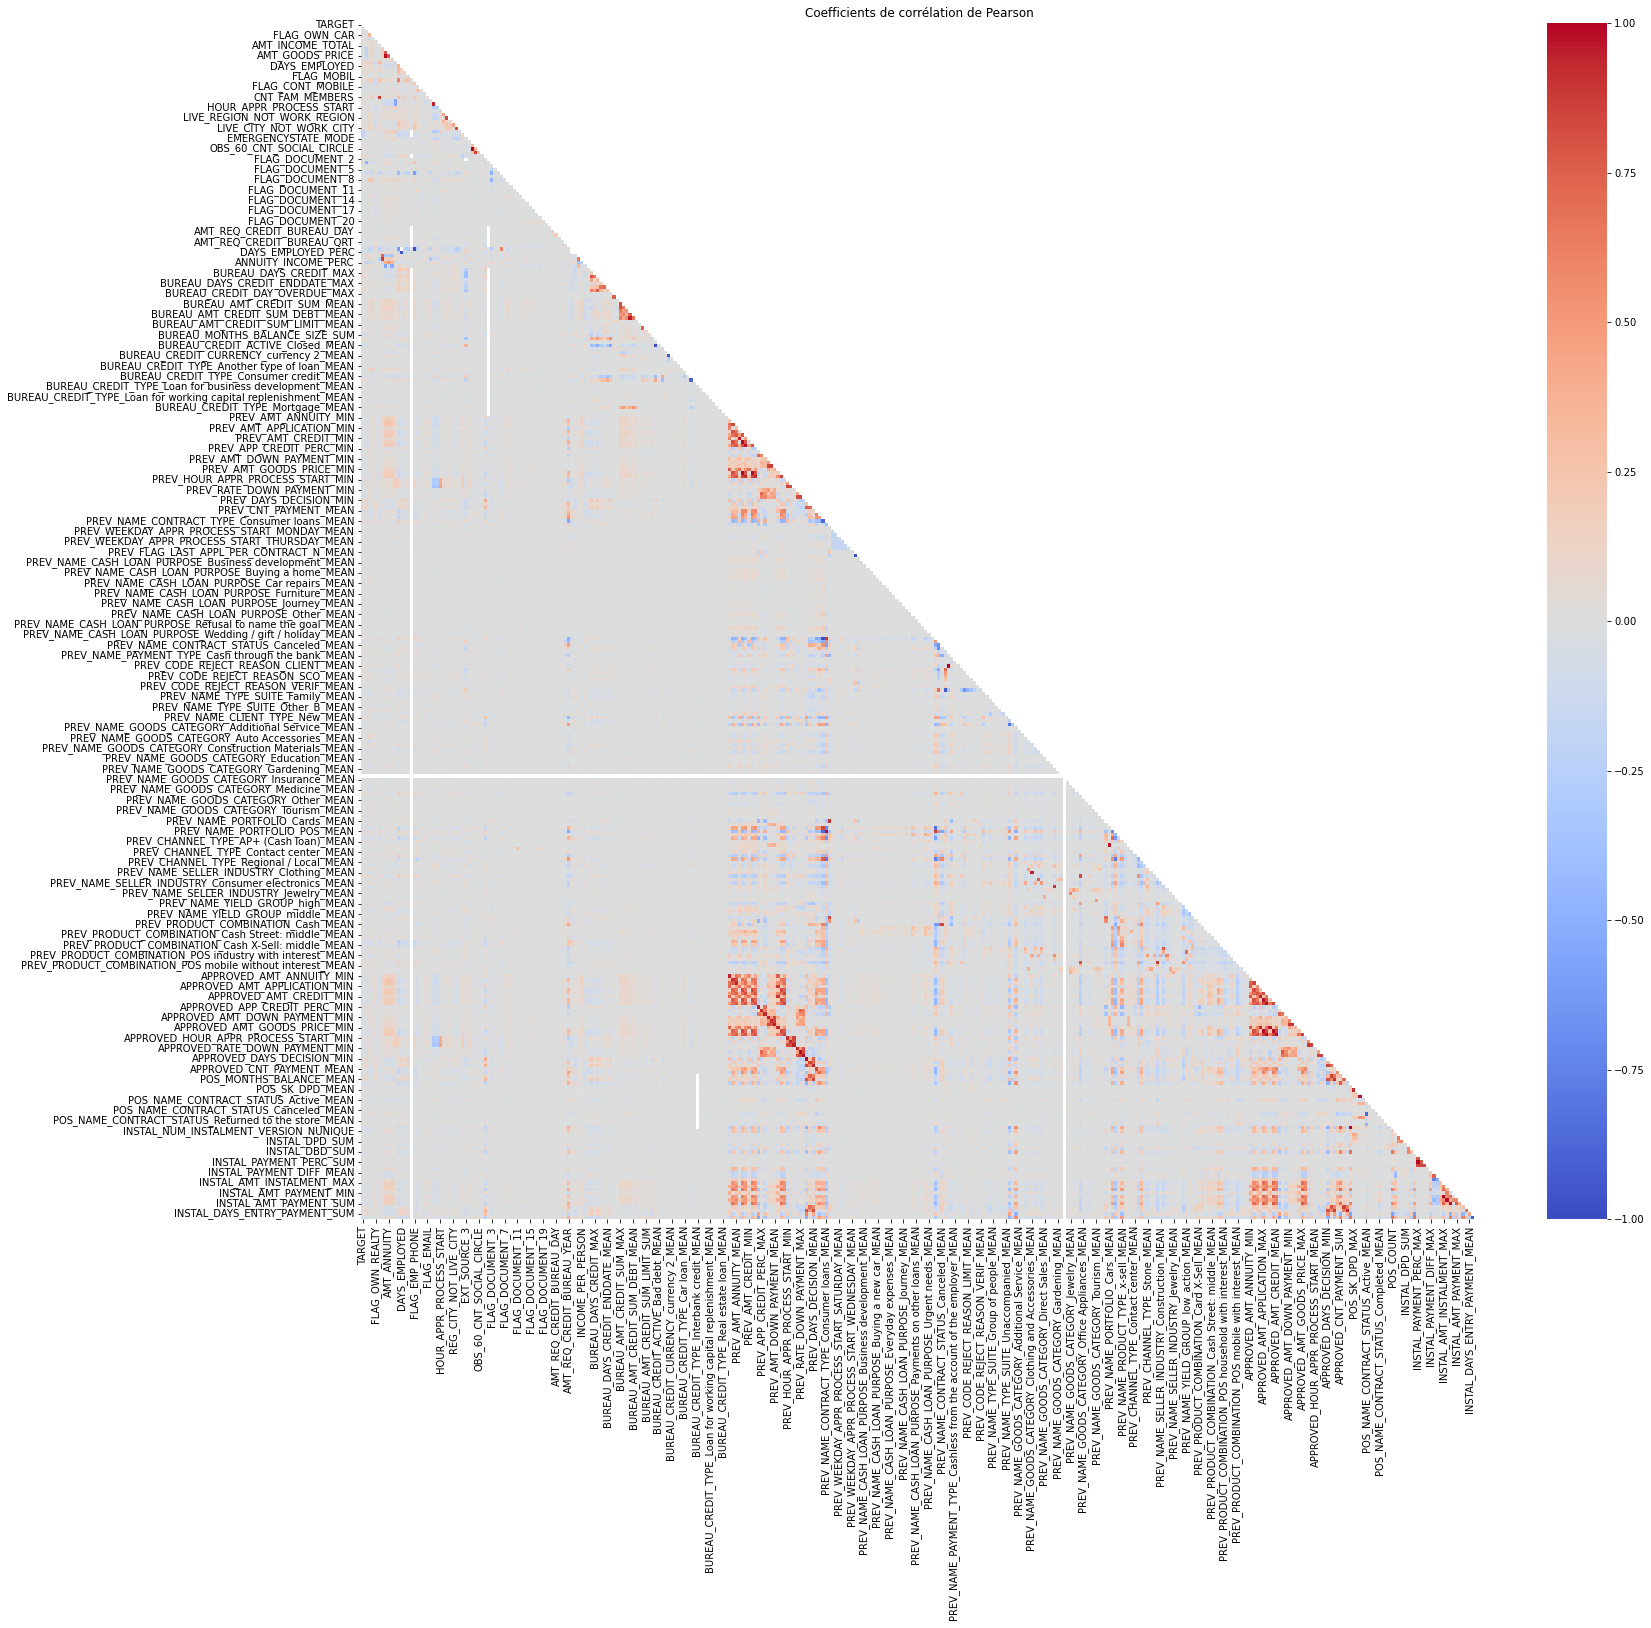

In [50]:
mask = np.triu(np.ones_like(corr, dtype=bool))

# graph
fig = plt.figure(figsize=(25, 22))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson")
plt.show()

In [51]:
# identification des paires n'ayant pas de coeff de correlation (NaN)
no_corr = corr.isna().unstack().reset_index()
no_corr.columns = ['feature_1', 'feature_2', 'non_correlees']
# selection des paires ayant un coeff de pearson à NaN
no_corr = no_corr[no_corr.non_correlees]
# no_corr.feature_2.value_counts()
# les features qui présentent autant de valeurs de NaN que le nb de features ne sont pas interessantes pour la suite
no_corr = no_corr.feature_2.value_counts()[no_corr.feature_2.value_counts() == data_final.shape[1]]
to_drop = list(no_corr.index)

# on garde forcement les variables AMT_Annuity, AMT_income_total et AMT_credit
for feature_to_keep in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'SK_ID_CURR']:
    if feature_to_keep in to_drop:
        to_drop.remove(feature_to_keep)

print("Il y a %d variables à supprimer" % len(to_drop))

Il y a 0 variables à supprimer


In [52]:
# corr_data: Matrice des corrélation avec NaN à la place des doublons
corr_data = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(bool))
# corr_data: Liste contenant les triplet (feature1, feature2, coefficient_corr)
corr_data = corr_data.unstack().reset_index()
corr_data.columns = ['feature_1', 'feature_2', 'pearson']
# On supprime les coefficients valant NaN (qui étaient des doublons)
corr_data.dropna(subset=['pearson'], inplace=True)
# On prend la valeur absolue arrondie à 3 chiffres des coefficients
corr_data['pearson'] = round(corr_data['pearson'], 3)
corr_data['pearson'] = abs(corr_data['pearson'])
corr_data = corr_data.sort_values(by='pearson', ascending=False)
corr_data

,feature_1,feature_2,pearson
61909,PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,1.0
101604,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_APPLICATION_MAX,1.0
64724,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,1.0
111347,POS_COUNT,POS_MONTHS_BALANCE_SIZE,1.0
53591,PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN,1.0
...,...,...,...
27473,BUREAU_CREDIT_DAY_OVERDUE_MEAN,AMT_REQ_CREDIT_BUREAU_DAY,0.0
114687,INSTAL_PAYMENT_PERC_SUM,PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / h...,0.0
58692,PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN,FLAG_DOCUMENT_12,0.0
79512,PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN,FLAG_DOCUMENT_12,0.0


<AxesSubplot:>

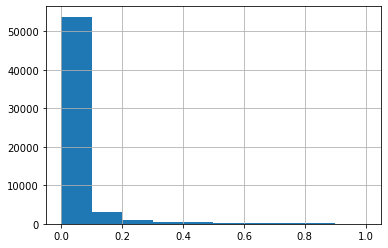

In [53]:
corr_data.pearson.hist()

In [54]:
# corr_min: Coefficient minimal pour considérer la corrélation comme forte
corr_min = 0.8
# corr_data_max: Va contenir les paire de variables fortement corrélées
corr_data_max = corr_data[corr_data['pearson'] >= corr_min]
print("Il y a %d corrélations fortes" % len(corr_data_max))


Il y a 166 corrélations fortes


pour chaque couple de variable fortement corrélé je garde la variable la plus corrélée à la cible

In [55]:
def lower_value(features, value):
    """Sélectionne la variable avec la value la plus faible entre deux variables."""
    feature1, feature2 = features.iloc[0], features.iloc[1]
    # print(feature1, feature2)
    # print(value[feature1], value[feature2])
    if value[feature1] > value[feature2]:
        aux = feature1
        feature1 = feature2
        feature2 = aux
    if feature1 in ['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'SK_ID_CURR']:
        aux = feature1
        feature1 = feature2
        feature2 = aux
    # print(feature1)
    return feature1

In [56]:
# corr_features: Va contenir la liste des variables à supprimer, car redondantes
# choix variable à supprimer = variable la moins corrélée à la cible
corr_features = corr_data_max[['feature_1', 'feature_2']]
corr_features = corr_features.apply(lower_value, args=(corr['TARGET'].map(abs),), axis=1)

print("cette liste regroupe {} variables qui seront supprimées".format(len(corr_features.unique())))


cette liste regroupe 89 variables qui seront supprimées


In [57]:
to_drop += list(corr_features.unique())

# on garde forcement les variables AMT_Annuity, AMT_income_total et AMT_credit
for feature_to_keep in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'SK_ID_CURR']:
    if feature_to_keep in to_drop:
        to_drop.remove(feature_to_keep)

print("Il y a %d variables à supprimer" % len(to_drop))

Il y a 88 variables à supprimer


In [58]:
# Suppression des variables listées dans to_drop
data_final = data_final.drop(columns=to_drop)
# mise à jour liste names_quali
liste_quali = [feature for feature in liste_quali if feature not in to_drop]
quali_categ = [feature for feature in quali_categ if feature not in to_drop]
print("il reste {} variables categorielles".format(len(liste_quali)))
data_final.shape

il reste 41 variables categorielles


(307177, 266)

### Variables catégorielles
#### Corrélation des variables categ avec la target
Pour déterminer le degré de corrélation des features avec la target il faut calculer eta².

In [59]:
def eta_squared(x ,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [60]:
anova = []
features = []
for feat in quali_categ:
    anova.append(eta_squared(data_final[feat],data_final.TARGET))
    features.append(feat)
res_anova = pd.DataFrame(np.column_stack([features, anova]), columns=['features', 'eta_squared'])
res_anova.sort_values(by='eta_squared', ascending=True)

,features,eta_squared
4,NAME_HOUSING_TYPE,0.001370133846424127
3,NAME_FAMILY_STATUS,0.0016492237374974537
2,NAME_EDUCATION_TYPE,0.003310384784167989
1,NAME_INCOME_TYPE,0.004078405612932737
6,ORGANIZATION_TYPE,0.0052325041832108656
5,WEEKDAY_APPR_PROCESS_START,4.8948437428068064e-05
0,NAME_TYPE_SUITE,nan


A priori toutes les variables catégorielles sont très peu corrélées à la target (eta² << 1) ==> ce n'est pas nécessaire de les garder

In [61]:
to_drop = quali_categ

print("Il y a %d variables à supprimer" % len(to_drop))

Il y a 7 variables à supprimer


In [62]:
data_final = data_final.drop(columns=to_drop)
# mise à jour liste liste_quali
liste_quali = [feature for feature in liste_quali if feature not in to_drop]
print("il reste {} variables categorielles".format(len(liste_quali)))
data_final.shape

il reste 34 variables categorielles


(307177, 259)

## Variables insuffisamment corrélées à la target

In [63]:
corr2 = data_final.corr()

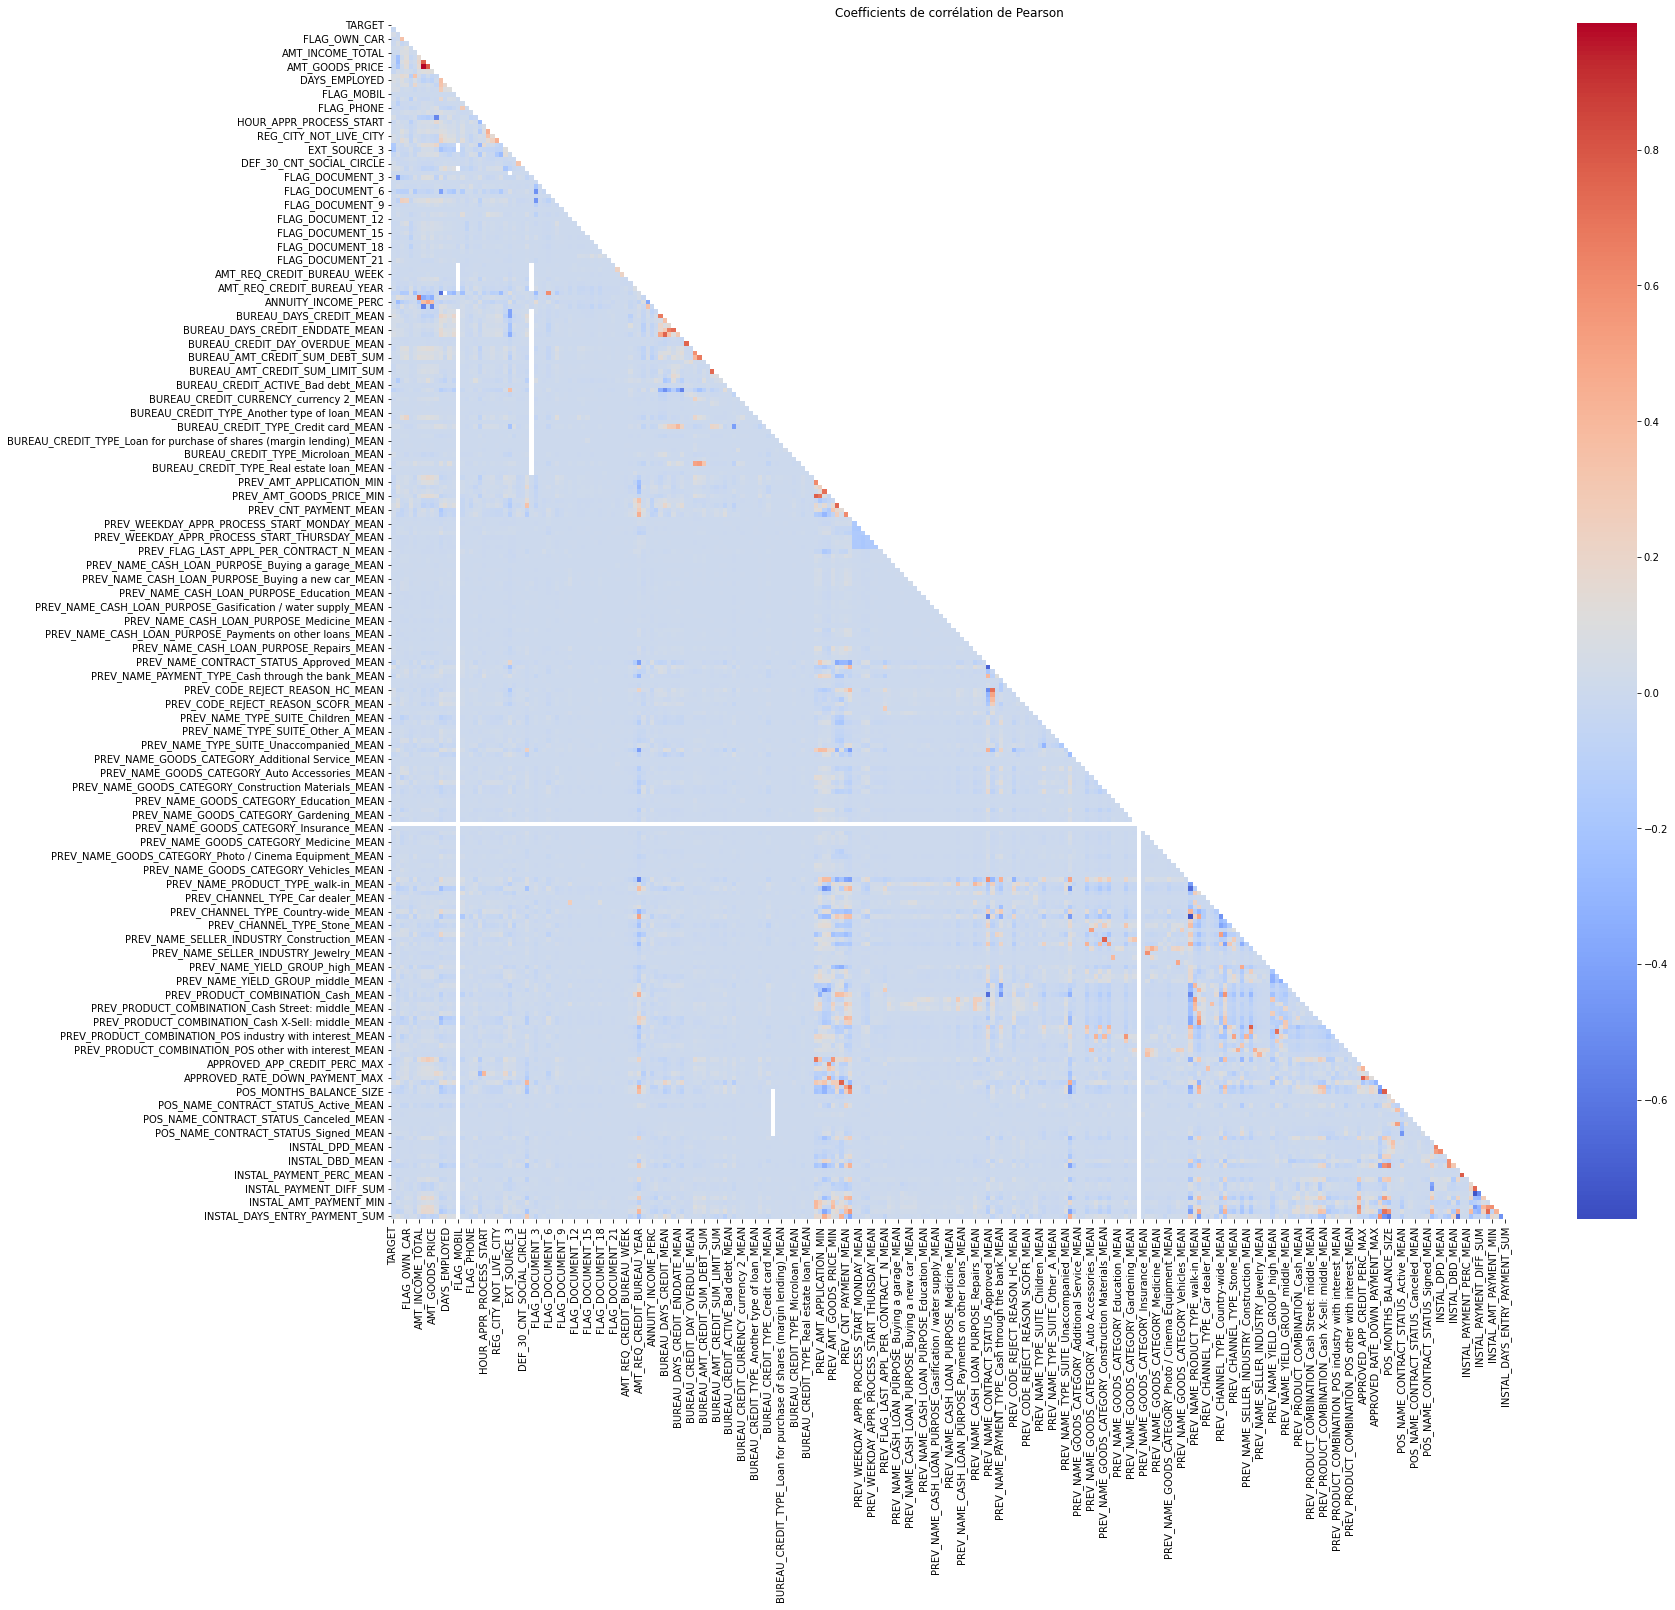

In [64]:
mask = np.triu(np.ones_like(corr2, dtype=bool))

# graph
fig = plt.figure(figsize=(25, 22))
sns.heatmap(data=corr2, mask=mask, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson")
plt.show()

In [65]:
# liste des correlations avec la target (en valeur absolue)
corr_target = corr2['TARGET'].abs().sort_values(ascending=False)
corr_target.dropna(inplace=True)
# selection des corrélations trop faibles
corr_target_faible = corr_target[corr_target < 0.05].index
print(len(corr_target_faible))
print("%d variables suffisamment corrélées à TARGET" % (len(data_final.columns)-len(corr_target_faible)))

239
20 variables suffisamment corrélées à TARGET


Les variables les plus corrélées à la target sont :

In [66]:
abs(corr_target.dropna()).sort_values(ascending=False).iloc[1:10]

EXT_SOURCE_3                               0.178836
EXT_SOURCE_2                               0.160438
BUREAU_DAYS_CREDIT_MEAN                    0.089714
BUREAU_CREDIT_ACTIVE_Closed_MEAN           0.079484
DAYS_BIRTH                                 0.078261
PREV_NAME_CONTRACT_STATUS_Refused_MEAN     0.077641
DAYS_EMPLOYED                              0.075061
BUREAU_DAYS_CREDIT_UPDATE_MEAN             0.068904
PREV_NAME_CONTRACT_STATUS_Approved_MEAN    0.063518
Name: TARGET, dtype: float64

In [67]:
to_drop = list(corr_target_faible.unique())

# on garde forcement les variables AMT_Annuity, AMT_income_total et AMT_credit
for feature_to_keep in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'SK_ID_CURR']:
    if feature_to_keep in to_drop:
        to_drop.remove(feature_to_keep)

print("Il y a %d variables à supprimer" % len(to_drop))

Il y a 236 variables à supprimer


In [68]:
# Suppression des variables listées dans to_drop
data_final = data_final.drop(columns=to_drop)
# mise à jour liste liste_quali
liste_quali = [feature for feature in liste_quali if feature not in to_drop]
print("il reste {} variables categorielles".format(len(liste_quali)))

data_final.shape

il reste 2 variables categorielles


(307177, 23)

In [69]:
# # retablissement des données catégorielles
# for feature in liste_quali:
#     data_final[feature] = label_enc[feature].inverse_transform(data_final[feature])
# data_final[liste_quali]

# Imputation
## Variables quantitatives : imputation par la moyenne

In [70]:
liste_quanti = [feature for feature in data_final.columns if feature not in liste_quali]

In [71]:
fct.pourcent_NA_df(data_final[liste_quanti])

Il y a 94.34% valeurs renseignées (soit 5.66 % de valeurs manquantes) dans l'intégralité du df


In [72]:
fct.taux_remplissage_colonne(data_final[liste_quanti])

,index,taux remplissage
0,TARGET,100.000000
1,DAYS_ID_PUBLISH,100.000000
2,AMT_CREDIT,100.000000
3,AMT_INCOME_TOTAL,100.000000
4,DAYS_BIRTH,100.000000
5,REGION_RATING_CLIENT_W_CITY,100.000000
6,DAYS_LAST_PHONE_CHANGE,99.999674
7,AMT_ANNUITY,99.996093
8,EXT_SOURCE_2,99.785140
9,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,94.643479


In [73]:
# mean_imputer: Imputeur par la moyenne
mean_imputer = SimpleImputer(strategy='mean')
mean_imputer.fit(data_final[liste_quanti])
# On impute les variables quantitatives
data_final[liste_quanti] = mean_imputer.transform(data_final[liste_quanti])

In [74]:
fct.pourcent_NA_df(data_final[liste_quanti])

Il y a 100.00% valeurs renseignées (soit 0.00 % de valeurs manquantes) dans l'intégralité du df


In [75]:
fct.pourcent_NA_df(data_final)

Il y a 100.00% valeurs renseignées (soit 0.00 % de valeurs manquantes) dans l'intégralité du df


## Variables qualitatives
imputation non nécessaire car il n'y a plus de variables quantitatives dans le jeu de données (variables insuffisamment corrélées à la target)

# EXPORT
## Sauvegarde des opérateurs de pré-traitement

In [78]:
# job_dir: Répertoire dans lequel enregistrer les fichier joblib
job_dir = './JOBLIB'
# dump(onehot_enc, job_dir + '/onehot_enc.joblib')
dump(mean_imputer, job_dir + '/mean_imputer.joblib')
for feature in liste_quali:
    dump(label_enc[feature], job_dir + '/label_encoder-' + feature + '.joblib')

  # Export des données pour la modélisation

In [77]:
print("Finalement, on a une table d'entraînement de %d individus et %d variables" % (data_final.shape[0], data_final.shape[1]))
data_final.to_csv('../01_DATA/data_for_modelling.csv')
pd.DataFrame(liste_quali).to_csv('../01_DATA/liste_quali.csv')


Finalement, on a une table d'entraînement de 307177 individus et 23 variables
